$\textbf{Visibility Equation}$


For this work, we simulate a HERA core antenna array,  with antennas closely packed  located at the PAPER site, Karoo South Africa.  We simulate true sky visibility for point sources seen by a baseline $\mathbf{b}_{\textit{a}\textit{b}}$ at frequency $\nu$:
$$
\begin{equation}
\textit{V}(\mathbf{b}_{\textit{a}\textit{b}},\nu)= \sum_{\textit{q}=1}^{\textit{N}_{\textrm{src}}} \textit{A}_{\textit{a}}^*(\hat{\mathbf{s}}_{\textit{q}},\nu)  \textit{A}_{\textit{b}}(\hat{\mathbf{s}}_{\textit{q}},\nu) \textit{S}_{\textit{q}}(\nu/\nu_0)^{-\alpha_{\textit{q}}} \textit{e}^{-2\pi j\frac{\nu}{\textit{c}}\mathbf{b}_{\textit{a}\textit{b}}\cdot \hat{\mathbf{s}}_{\textit{q}}}
\end{equation}
$$
where  $\textit{A}_{\textit{a}}(\hat{\mathbf{s}}_{\textit{q}},\nu)$ and $\textit{A}_{\textit{b}}(\hat{\mathbf{s}}_{\textit{q}},\nu)$ are primary beam of antenna $\textit{a}$ and $\textit{b}$ measured at a point source location $\hat{\mathbf{s}}_{\textit{q}}$  with flux density $\textit{S}_{\textit{q}}$. Here $\nu_0$ and $\alpha_{\textit{q}}$ are the central frequency and spectral index of each point source. $^*$ complex conjugate and $j=\sqrt{-1}$

And observed visibility:
$$
\begin{equation}
   \textit{V}(\mathbf{b}_{\textit{a}\textit{b}},\nu) = \textit{g}_{\textit{a}}(\nu)^{*}\textit{g}_{\textit{b}} \textit{u}(\mathbf{b}_{\textit{a}\textit{b}},\nu) + \textit{n}_{\textit{a}\textit{b}}(\nu)
\end{equation}
$$
where $\textit{g}_{\textit{a}}$ and $\textit{g}_{\textit{b}}$ are the  directional indpendent eantenna gains. Here $\textit{n}_{\textit{a}\textit{b}}$ is the complex visibility noise, and is given by 
$$
\begin{equation}
  \textit{n}_{\textit{a}\textit{b}}(\nu,\textit{t})=  < \sigma_{\textit{a}}(\nu,\textit{t})\sigma_{\textit{b}}^*(\nu,\textit{t})>
\end{equation}
$$
where $\sigma_{\textit{a}}$ and $\sigma_{\textit{b}}$ are antenna noise defined as 
$$
\begin{equation}\label{eq:radm}
    \sigma(\nu) = \frac{\textit{T}_{\textrm{sys}}(\nu,\textit{t})}{\sqrt{\Delta \nu \Delta \textit{t}}}
\end{equation}
$$
where $\textit{T}_{\textrm{sys}}$ antenna system temperature, and $\Delta \nu$ and $\Delta \textit{t}$ are frequency bandwidth and time integration per observation, respectively.

http://math_research.uct.ac.za/~siphelo/admin/interferometry/3_Positional_Astronomy/3_4_Direction_Cosine_Coordinates.html

In [1]:
%run beam_simulator.py
%run visibility_simulator.py
%matplotlib inline
%run antpos
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import astropy.coordinates as coord
import astropy.units as u
from astropy import time
from matplotlib.colors import LogNorm
import scipy.constants as CNST1
from scipy import signal


$\textbf{GLEAM Calague Flux above 15 Jy 100-200 MHz}$

Detail of how/where to download GLEAM Catalogue and data manipulation are discussed in this jupyter notebook:


https://github.com/UKZN-Astronomy/hera_corrcal/blob/master/Simulations/Preparing%20GLEAM%20Source%20Catague.ipynb

In [2]:
#loadinng GLEAM Calague 70-200 MHz
datafile = pd.read_csv('GLEAM_Catalogue_flux_above_15Jy_70_237MHz.csv')

df = pd.DataFrame(data=datafile)

#Flux and spectral indeces best fit

data_bestfit = np.load('GLEAM_Catalogue_flux_above_15Jy_100_200MHz_best_fit_S_0_alpha.npy')

RA = np.deg2rad(df['RAJ2000'])
DEC =np.deg2rad(df['DEJ2000'])

$\textbf{GLEAM Bright Point Source Spartial Distribution}$

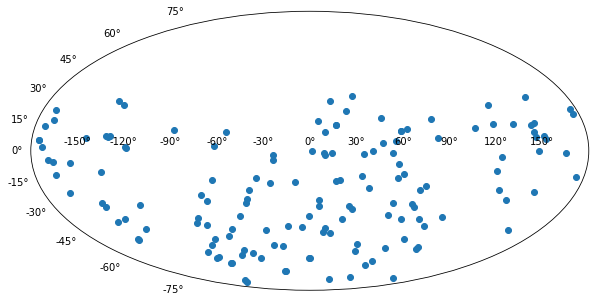

In [3]:
ra = coord.Angle(df['RAJ2000']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df['DEJ2000']*u.degree)

RA_0, DEC_0 = 21.41100,-30.72100 #degrees
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)


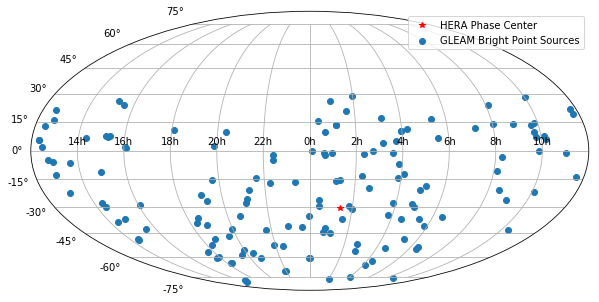

In [4]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian,label='GLEAM Bright Point Sources')
ax.plot(np.deg2rad(RA_0),np.deg2rad(DEC_0),'*r',label='HERA Phase Center')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.legend(loc='best')
ax.grid(True)

$\textbf{Antenna Layout in ENU System}$

number of Antennas 19


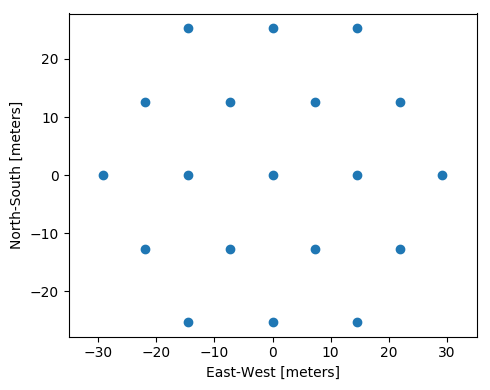

In [5]:
antposs = hex_array(3,split_core= False, outriggers=0)

hera_hex_pos = np.array([list(pos) for pos in antposs.values()])

print 'number of Antennas', len(hera_hex_pos[:,0])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(hera_hex_pos[:,0],hera_hex_pos[:,1])
plt.xlabel("East-West [meters]")
plt.ylabel("North-South [meters]")
plt.axis('equal')
plt.tight_layout()


$\textbf{Transform from ENU to XYZ}$


For a detailed discussion refer to lecture https://web.njit.edu/~gary/728/Lecture6.html

$$
 \begin{gather}
 \begin{bmatrix} X  \\ Y \\ Z \end{bmatrix}
 =
  \begin{bmatrix}
   0 & -\sin(lat) &\cos(lat) \\
  1 & 0 & 0 \\
  0 & \cos(lat) & \sin(lat)
  \end{bmatrix} 
  \begin{bmatrix} E  \\ N \\ U \end{bmatrix}
\end{gather}
$$

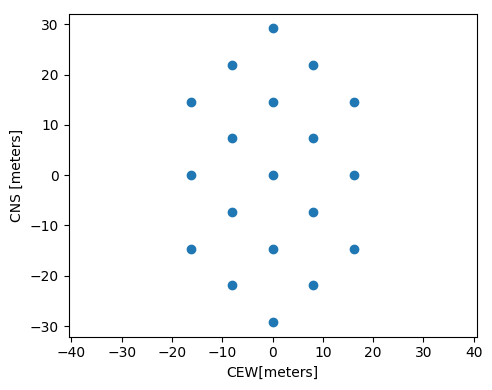

In [6]:
#HERA latitude on Earth Surface
lat = -30.722

XYZ_array = np.array([XYZ_trans_mat(hera_hex_pos[i],lat)[0] for i in range(len(hera_hex_pos))])

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(XYZ_array[:,0],XYZ_array[:,1])
plt.xlabel("CEW[meters]")
plt.ylabel("CNS [meters]")
plt.axis('equal')
plt.tight_layout()




$\textbf{Computing Baseline Vectors}$


With 19 antennas there are 30 unique baselines.
1830 baselines


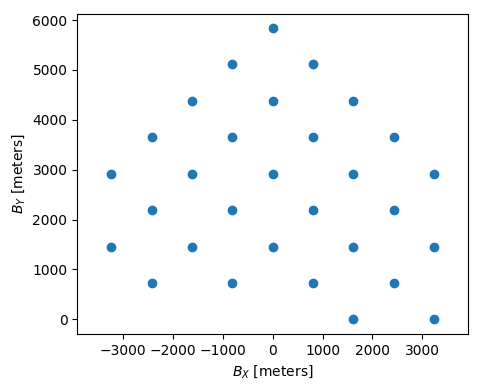

In [7]:


ants_indices = np.arange(len(XYZ_array))

ublDict = InterferometricArray(XYZ_array,ants_indices).CalculateUBLs()[4] #computing Unique Baselines
print 61*60/2 ,"baselines"

B_xyz = np.array(ublDict.keys())

plt.figure(figsize=(5,4), dpi=100)
plt.scatter(B_xyz[:,0],B_xyz[:,1])
plt.xlabel(r"$B_X$ [meters]")
plt.ylabel(r"$B_Y$ [meters]")
plt.axis('equal')
plt.tight_layout()



$$\textbf{Transform from $\textit{B}_{\textrm{XYZ}}$ to $\textit{uvw}$ }$$


For a detailed discussion refer to lecture https://web.njit.edu/~gary/728/Lecture6.html

Below is direction cosine matrix transformation of $\textit{B}_{\textrm{XYZ}}$ to the direction peperndicular to the phase center ($\textit{h}_0,\delta_0$), thus forming $\textit{uvw}$ 

$$
 \begin{gather} 
 \begin{bmatrix} \textit{u}  \\ \textit{v}\\ \textit{w} \end{bmatrix}
 =\frac{1}{\lambda}
  \begin{bmatrix}
   \sin\textit{h}_0 & \cos\textit{h}_0 & 0 \\
  -\sin\delta_0\cos\textit{h}_0 & sin\delta_0\sin\textit{h}_0 & \cos\delta_0 \\
  \cos\delta_0\cos\textit{h}_0 &-\cos\delta_0\sin\textit{h}_0 & \sin\delta_0
  \end{bmatrix} 
  \begin{bmatrix} \textit{B}_{\textit{X}}  \\ \textit{B}_{\textit{Y}} \\ \textit{B}_{\textit{Z}}\end{bmatrix}
\end{gather}
$$

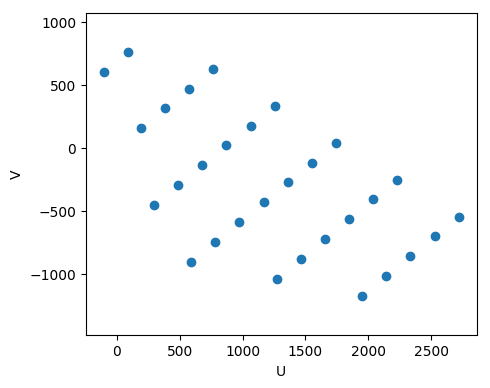

In [9]:
freq_mid =150e6 # Hz
wavelen = 3.0*10**8/freq_mid 
uvw = np.array([baseline_proj(B_xyz[i],RA_0,DEC_0)[0]*1.0/wavelen for i in range(len(B_xyz))])



plt.figure(figsize=(5,4), dpi=100)
plt.scatter(uvw[:,0],uvw[:,1])
plt.xlabel(r"U")
plt.ylabel(r"V")
plt.axis('equal')
plt.tight_layout()


$\textbf{Converting from the equatorial to direction cosine coordinates}$

$$
\begin{equation}
\textit{l}= cos\delta \sin\Delta \textit{h}
\end{equation}
$$

$$
\begin{equation}
\textit{m}= \sin\delta \cos\delta_0 -\cos\delta \sin\delta_0 \cos\Delta \textit{h}
\end{equation}
$$

$$
\begin{equation}
\textit{n} = \sqrt{1-(\textit{l}^2 +\textit{m}^2)}
\end{equation}
$$

where $\textit{l}$, $\textit{m}$ and $\textit{n}$ are direction cosine. Here $(\delta,\textit{h})$ is position on the celestial sphere, and $(\delta_0,\textit{h}_0)$ is phase center of the array, and $\Delta \textit{h} = \textit{h}-\textit{h}_0$.


$\textbf{Equatorial Co-ordinates to local Horizontal Co-ordinates}$



$$
\begin{equation}
\sin(\textrm{altitude}) = \sin(\textrm{latitude})\sin(\delta) + \cos(\textrm{latitude})\cos(\delta)\cos(\textit{h})
\end{equation}
$$
$$
\begin{equation}
\tan(azimuth) = -\frac{\sin\textit{h}}{\cos(\textrm{latitude})\tan\delta  - \sin(\textrm{latitude})  \cos\textit{h}}
\end{equation}
$$

where $\textrm{latitude}$ is position of telescope on Earth. The star hour angle with position ( $(\delta,\textit{h})$ is given by

$$
\begin{equation}
\textrm{SHA} = \textit{LST }-\textit{h}
\end{equation}
$$

where $\textit{LST }$ is the local sidereal time.

$$
\begin{equation}
\textit{h}_{rad}= \frac{\pi}{12}(\textit{h} +\frac{m}{60}+ \frac{s}{3600})
\end{equation}
$$

$$
\begin{equation}
\delta_{rad}=\frac{π}{180}(\textit{d}+ \frac{m_{arcmin}}{60}+\frac{s_{arcsec}}{3600})
\end{equation}
$$

reference:

http://math_research.uct.ac.za/~siphelo/admin/interferometry/3_Positional_Astronomy/3_4_Direction_Cosine_Coordinates.html


http://www.jgiesen.de/elevaz/basics/

http://www.jgiesen.de/astro/astroJS/siderealClock/

In [10]:
def pos_lmn(ra,dec,ra_0,dec_0):
    
    l=np.cos(dec)*np.sin(ra-ra_0)
    m=np.sin(dec)*np.cos(dec_0)-np.cos(dec)*np.sin(dec_0)*np.cos(ra-ra_0)
    n = np.sqrt(1-(l**2 + m**2))
    
    return np.array([l,m,n])

def convert_radec_alt_az(ra,dec,telescope_lat):
    
    alt = np.arcsin(np.sin(telescope_lat)*np.sin(dec) + np.cos(telescope_lat)*np.cos(dec)*np.cos(ra))
    az  = np.arctan(np.sin(ra)/(np.cos(telescope_lat)*np.tan(dec) -np.sin(telescope_lat)*np.cos(ra)))
    return np.array([alt,az])
                    
    
#HERA Phase Center
RA_0,DEC_0 = 21.41100,-30.72100
LST =(np.pi/12.0)*(4.0 + 7.0/60.0 + 40.0/3600)

def cat_poslmn_above_horizon(RA,DEC,RA_0,DEC_0,LST):
    
    src_radec =[]
    src_pos_lmn =[]
    for src_i in range(len(RA)):
        SHA = LST -RA[src_i]
        alt = convert_radec_alt_az(SHA,DEC[src_i],np.deg2rad(DEC_0))[0]
    
        if alt<= 0.0:
            pass
        
        else:
        
            #print src_i, 'above the horizon'
        
            src_pos_lmn.append(pos_lmn(SHA,DEC[src_i],np.deg2rad(RA_0),np.deg2rad(DEC_0)))
            src_radec.append([SHA,DEC[src_i]])
          
            
            
    return [np.array(src_pos_lmn),np.array(src_radec)]
        
    
radec =cat_poslmn_above_horizon(RA,DEC,RA_0,DEC_0,LST)[1]


                    

$\textbf{ Gaussian Primary Beam Model}$

The simplest primary beam model is Gaussain beam, it a good approximation of main lobe. It is a good enough to capture antenna-to-antenna variation due to pointing errors and spectral variation of ful l-width-half-maximum. A two dimensional Gaussian beam centered at ($\theta_c,\phi_c$) and   measure at angular co-ordinate $(\theta,\phi)$
$$
\begin{equation}
        \textit{A}(\theta,\phi,\nu)= \frac{1}{\sqrt{2\pi((\sigma(\nu) + \varepsilon_{\sigma}(\nu))^2}}\textit{e}^{-\frac{(\theta - (\theta_c + \varepsilon_{\theta}))^2 + (\phi+ -(\phi_c\varepsilon_{\phi}))^2}{2(\sigma(\nu) + \varepsilon_{\sigma}(\nu))^2}}
\end{equation}
$$
where $\varepsilon_{\theta}$ and $\varepsilon_{\phi}$ are pointing errors, and $\varepsilon_{\sigma})$ is the beam size/shape error and, is given by
$$
\begin{equation}
\varepsilon_{\sigma}(\nu) = \kappa\sigma(\nu)
\end{equation}
$$
where $\kappa$ is fractional error of the full-width-half-maximum . $\sigma$ is approximated from FWHM of ariy disk, 
$$
\begin{equation}
        \sigma \approx 0.44\frac{\lambda}{\textit{D}}
\end{equation}
$$
. Here $\textit{D}$ dish diameter.

reference

https://courses.lumenlearning.com/austincc-physics2/chapter/27-6-limits-of-resolution-the-rayleigh-criterion/

https://stackoverflow.com/questions/31573572/healpy-from-data-to-healpix-map


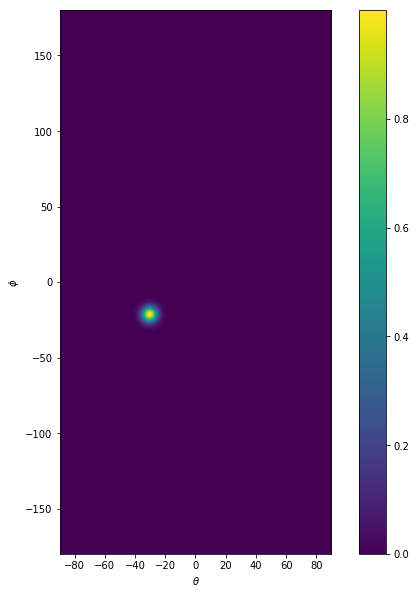

In [5]:
npoints =1000
freq_mid = 150e6
sigma_fwhm = sigma_func(14.0,freq_mid)
RA_0,DEC_0 = 21.41100,-30.72100
theta, phi = np.linspace(-np.pi/2.0,np.pi/2.0,npoints),np.linspace(-np.pi,np.pi,npoints)

gaussin_2d = np.zeros((phi.size,theta.size))
for phi_i in range(len(phi)):
    for theta_j in range(len(theta)):
        
        #print theta_j,phi_i, gaussin_2d[phi_i][theta_j],gaussian_beam(theta[theta_j],phi[phi_i],sigma_fwhm,0.0,0.0,0.0)
        
        gaussin_2d[phi_i][theta_j] = gaussian_beam(np.deg2rad(DEC_0),np.deg2rad(RA_0),theta[theta_j],phi[phi_i],sigma_fwhm,0.0,0.0,0.0)
        
        
extent = [np.rad2deg(theta[0]),np.rad2deg(theta[-1]),np.rad2deg(phi[0]),np.rad2deg(phi[-1])]      
plt.figure(figsize=(10,10))
plt.imshow(gaussin_2d,extent=extent)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\phi$')
plt.colorbar()

In [3]:
np.angle?

$\textbf{Visibility Simulation Point Source}$


In [11]:
#Test point source
#We use best fit of central flux at 151 MHz and spectral index
flux_central,spectral_ind = data_bestfit[0][0],data_bestfit[0][1]

print flux_central,spectral_ind

flux_func = lambda f,s_0,alpha : s_0*np.power(151.0/f,alpha)

97.8702559351418 0.4659824453272525


In [12]:
lsts = np.arange(0.0,2.0*np.pi,np.deg2rad(1.0))
freqs = np.arange(100.0,200.0,0.1)


ant1_pos = np.array([0.0,0.0,0.0]) # reference antenna position in ENU coordinate system
ant2_pos = np.array([14.6,0.0,0.0])
d_block =0.0
#parametized airydisk

a_x = 7.0 #np.random.normal(6.0,0.01)
a_y = 7.0 #np.random.normal(6.0,0.01)



d_diam = 14.0 
ant1_theta_error,ant1_phi_error, ant2_theta_error,ant2_phi_error,Ant1_beam_size_error,Ant2_beam_size_error = 0.0,0.0,0.0,0.0,0.0,0.0

In [13]:

vis_gp =np.zeros((lsts.size,freqs.size),dtype='complex')
vis_ad =np.zeros((lsts.size,freqs.size),dtype='complex')
src_ps = np.zeros((lsts.size,3))
ra_src =(np.deg2rad(RA_0) + np.pi/2.0)
for lst_i in range(lsts.size):
            #star hour angle
            ra= lsts[lst_i] - ra_src
        
            src_pos_lmn = pos_lmn(ra,np.deg2rad(DEC_0),np.deg2rad(RA_0),np.deg2rad(DEC_0))
            
            src_ps[lst_i] = src_pos_lmn
            #transforming antenna position from ENU to equatorial system XYZ
            lat = np.deg2rad(DEC_0)
            xyz_1,xyz_2 = XYZ_trans_mat(ant1_pos,lat)[0],XYZ_trans_mat(ant2_pos,lat)[0]
            
            #computing the baseline
            bl_xyz = xyz_2 - xyz_1

            #compute the visibility for all frequency
            vis_freq_gp = np.zeros(freqs.size,dtype ='complex')
            vis_freq_ad = np.zeros(freqs.size,dtype ='complex')
            
            for freq_i in range(freqs.size):
                lambda_ = (3e8)/(freqs[freq_i]*10**6)
                sigma_fwhm = sigma_func(d_diam,freqs[freq_i]*10**6)
                vis_freq_gp[freq_i]= flux_func(freqs[freq_i],flux_central,spectral_ind)*gaussian_beam(np.deg2rad(DEC_0),np.deg2rad(RA_0),np.deg2rad(DEC_0),ra,sigma_fwhm,0.0,0.0,0.0)*gaussian_beam(np.deg2rad(DEC_0),np.deg2rad(RA_0),np.deg2rad(DEC_0),ra,sigma_fwhm,0.0,0.0,0.0)*np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/lambda_,src_pos_lmn))
                vis_freq_ad[freq_i]= flux_func(freqs[freq_i],flux_central,spectral_ind)*param_airydisk(np.deg2rad(DEC_0),np.deg2rad(RA_0),np.deg2rad(DEC_0),ra,a_x,a_y,d_diam,d_block,freqs[freq_i]*10**6)*param_airydisk(np.deg2rad(DEC_0),np.deg2rad(RA_0),np.deg2rad(DEC_0),ra,a_x,a_y,d_diam,d_block,freqs[freq_i]*10**6)*np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/lambda_,src_pos_lmn))
            vis_gp[lst_i,:] = vis_freq_gp
            vis_ad[lst_i,:] = vis_freq_ad
                
 






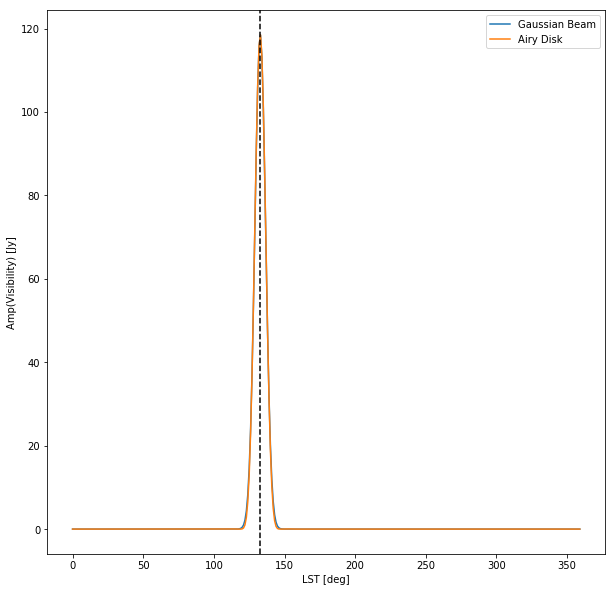

In [14]:

plt.figure(figsize =(10,10))
plt.plot(np.rad2deg(lsts),np.abs(vis_gp[:,0]),label='Gaussian Beam')
plt.plot(np.rad2deg(lsts),np.abs(vis_ad[:,0]),label='Airy Disk')
plt.axvline(np.rad2deg(lsts[133]),ls='dashed',color='black')
plt.xlabel('LST [deg]')
plt.ylabel('Amp(Visibility) [Jy]')
plt.legend(loc='best')
                    

111.411


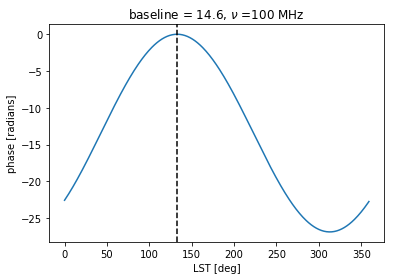

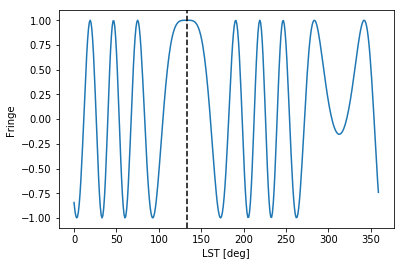

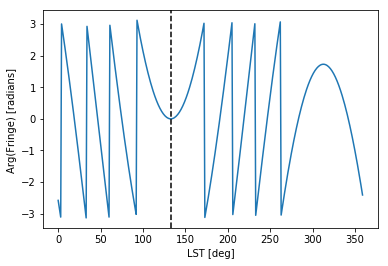

In [16]:
#fringe

phase = [2.0*np.pi*np.dot(bl_xyz,src_ps[i])*(freqs[0]*10**6)/3e8 for i in range(len(src_ps))]

fringe=[ np.exp(-1j*phase[i]) for i in range(len(phase))]
print np.rad2deg(ra_src)
plt.title(r'baseline = 14.6, $\nu$ =100 MHz')
plt.plot(np.rad2deg(lsts),phase)
plt.axvline(np.rad2deg(lsts[133]),ls='dashed',color='black')
plt.xlabel('LST [deg]')
plt.ylabel('phase [radians]')
plt.show()

plt.plot(np.rad2deg(lsts),fringe)
plt.axvline(np.rad2deg(lsts[133]),ls='dashed',color='black')
plt.xlabel('LST [deg]')
plt.ylabel('Fringe ')
plt.show()


plt.plot(np.rad2deg(lsts),np.angle(fringe))
plt.axvline(np.rad2deg(lsts[133]),ls='dashed',color='black')
plt.xlabel('LST [deg]')
plt.ylabel('Arg(Fringe) [radians] ')
plt.show()



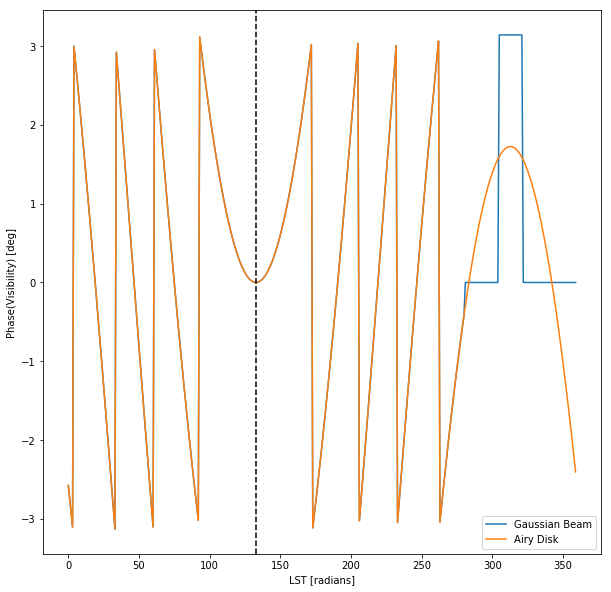

In [17]:
plt.figure(figsize =(10,10))
plt.plot(np.rad2deg(lsts),np.angle(vis_gp[:,0]),label='Gaussian Beam')
plt.plot(np.rad2deg(lsts),np.angle(vis_ad[:,0]),label='Airy Disk')
plt.axvline(np.rad2deg(lsts[133]),ls='dashed',color='black')
plt.xlabel('LST [radians]')
plt.ylabel('Phase(Visibility) [deg]')
plt.legend(loc='best')


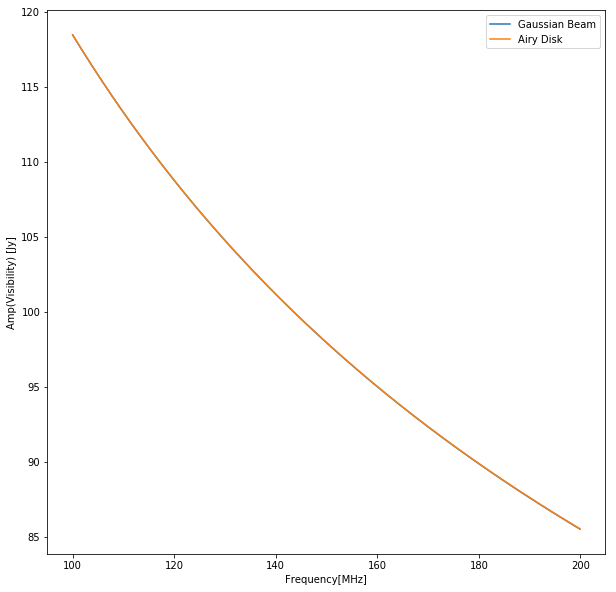

In [18]:
plt.figure(figsize =(10,10))
plt.plot(freqs,np.abs(vis_gp[133]),label='Gaussian Beam')
plt.plot(freqs,np.abs(vis_ad[133]),label='Airy Disk')
plt.xlabel('Frequency[MHz]')
plt.ylabel('Amp(Visibility) [Jy]')
plt.legend(loc='best')


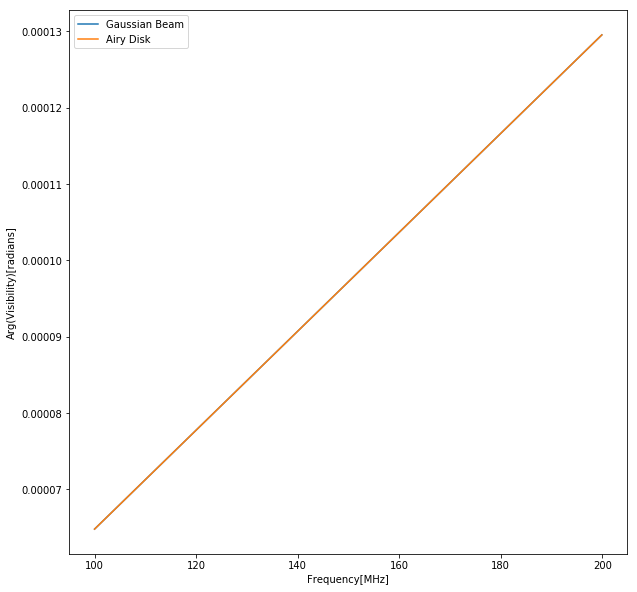

In [19]:
plt.figure(figsize =(10,10))
plt.plot(freqs,np.angle(vis_gp[133]),label='Gaussian Beam')
plt.plot(freqs,np.angle(vis_ad[133]),label='Airy Disk')
plt.xlabel('Frequency[MHz]')
plt.ylabel('Arg(Visibility)[radians]')
plt.legend(loc='best')

$\textbf{Visibility Waterfall}$

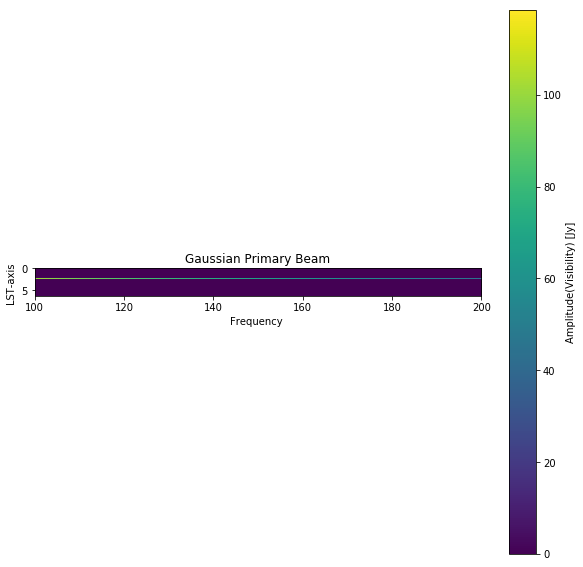

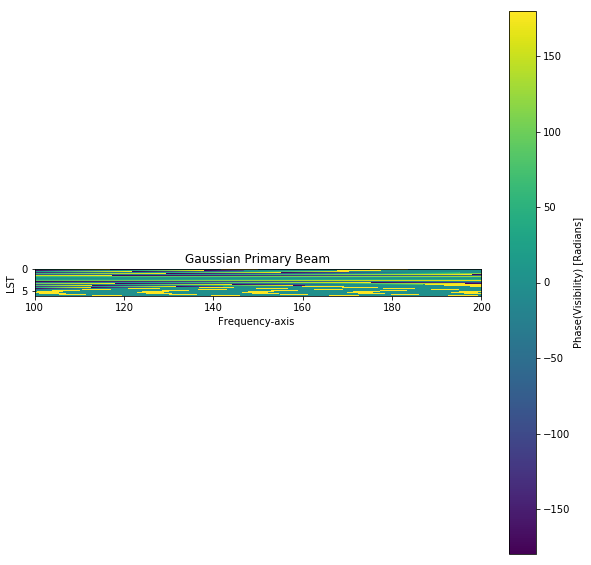

In [20]:
extent =[freqs[0],freqs[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("Gaussian Primary Beam")
plt.imshow(np.abs(vis_gp),extent=extent)
plt.xlabel('Frequency ')
plt.ylabel('LST-axis ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Gaussian Primary Beam")
plt.imshow(np.angle(vis_gp,deg='deg'),extent=extent)
plt.xlabel('Frequency-axis ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

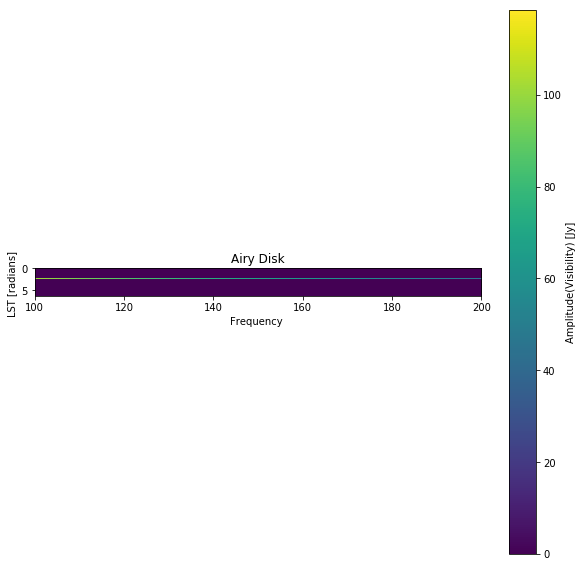

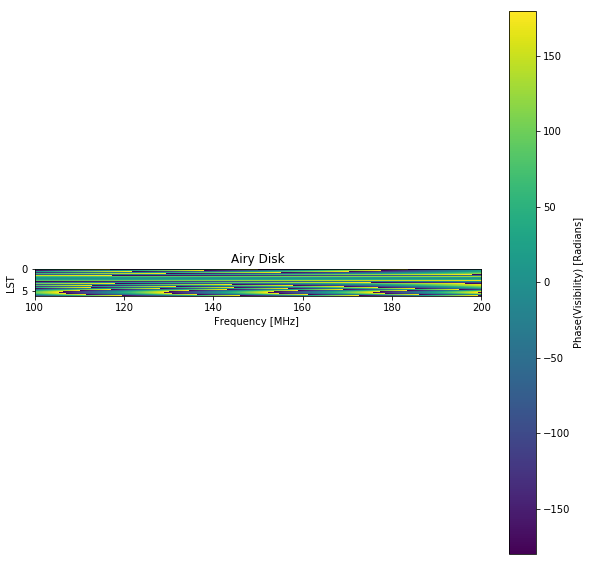

In [22]:
extent =[freqs[0],freqs[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.abs(vis_ad),extent=extent)
plt.xlabel('Frequency ')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.angle(vis_ad,deg='deg'),extent=extent)
plt.xlabel('Frequency [MHz] ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

$\textbf{Delay Visibility}$

In [25]:
def get_bandwidth(window_func,frqs,dfreq =1.0):
    "This function compute the bandwidth given the window function as an array, and freqs array where it is sampled"
    
    bandwidth = intg.simps(window_func,frqs,dfreq)
    
    return bandwidth

window = signal.nuttall(freqs.size)


def get_delay_vis(data,window,frqs):
    delay_data=np.fft.ifft(data*window)
    delaydata_shift=np.fft.fftshift(delay_data)
    delays = np.fft.fftfreq(frqs.size,frqs[1]-frqs[0])
    delays = np.fft.fftshift(delays)
    
    return [delays,delaydata_shift]

frq_mid = 150 # Central frequency in MHz
c=3e8
jy2mK = 1e-26*(c/(frq_mid*1e6))**2/(2*CNST1.k)*1e3



ant1_pos = np.array([0.0,0.0,0.0]) # reference antenna position in ENU coordinate system
ant2_pos = np.array([14.6,0.0,0.0])
bl = np.linalg.norm(ant2_pos-ant1_pos)

def geometric_delay(bl):
    return bl/c

bl= 14.6
g_dl = geometric_delay(bl)

ddata_gb = np.array([get_delay_vis(vis_gp[lst_i]*jy2mK,window,freqs)[1] for lst_i in range(vis_gp.shape[0])])
ddata_ad = np.array([get_delay_vis(vis_ad[lst_i]*jy2mK,window,freqs)[1] for lst_i in range(vis_ad.shape[0])])

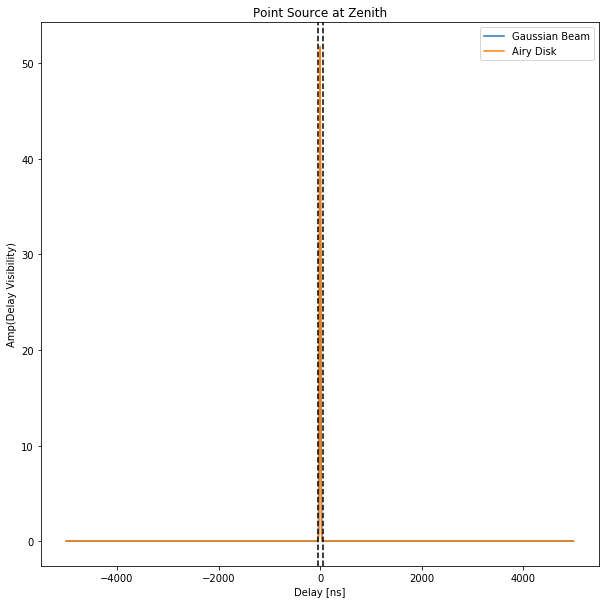

In [26]:
delays = np.fft.fftfreq(freqs.size,freqs[1]*10**6 -freqs[0]*10**6)
delays = np.fft.fftshift(delays)*10**9

plt.figure(figsize=(10,10))
plt.title('Point Source at Zenith')
plt.plot(delays,np.abs(ddata_gb[133]),label='Gaussian Beam')
plt.plot(delays,np.abs(ddata_ad[133]),label='Airy Disk')
plt.axvline(g_dl*10**9,ls='dashed',color='black')
plt.axvline(-g_dl*10**9,ls='dashed',color='black')
plt.xlabel('Delay [ns]')
plt.ylabel('Amp(Delay Visibility)')
plt.legend(loc='best')


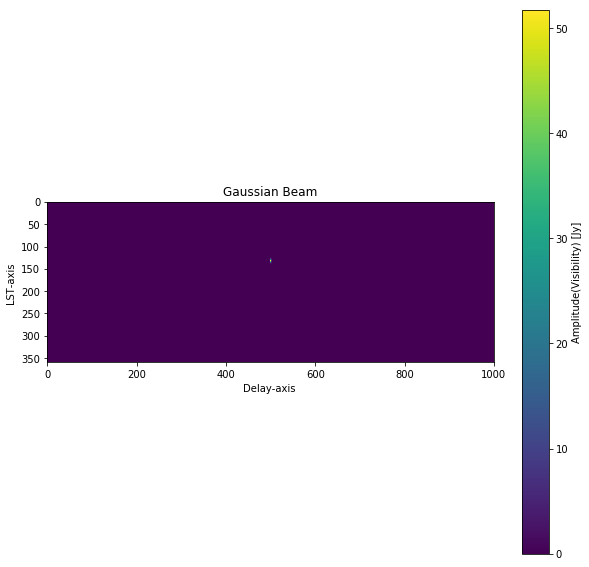

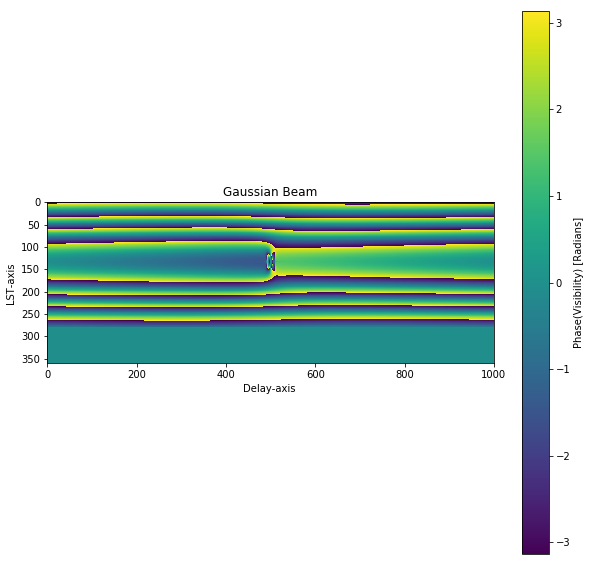

In [30]:

delays = np.fft.fftfreq(freqs.size,freqs[1]*10**6-freqs[0]*10**6)
delays = np.fft.fftshift(delays)
extent =[delays[0],delays[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("Gaussian Beam")
plt.imshow(np.abs(ddata_gb))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay-axis ')
plt.ylabel('LST-axis ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Gaussian Beam")
plt.imshow(np.angle(ddata_gb))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay-axis ')
plt.ylabel('LST-axis ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()


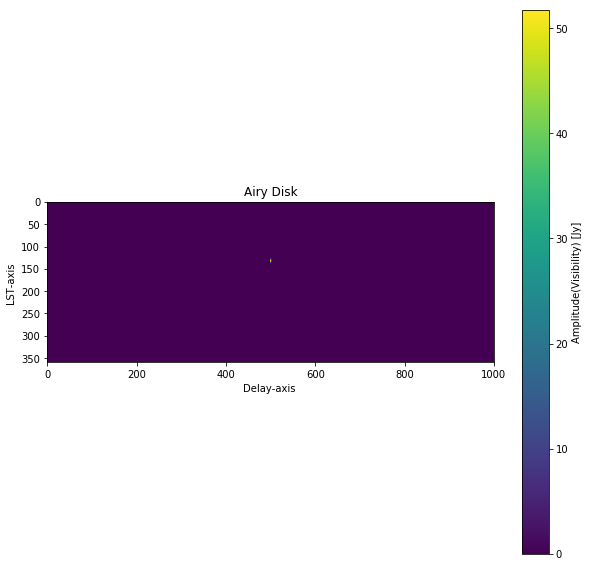

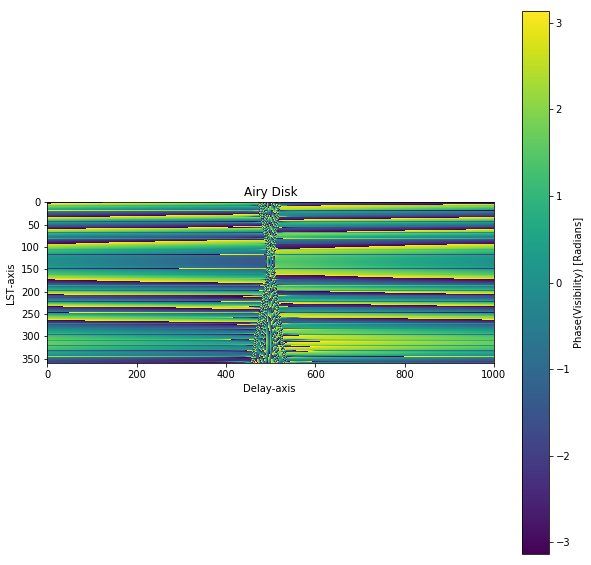

In [31]:

plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.abs(ddata_ad))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay-axis ')
plt.ylabel('LST-axis ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.angle(ddata_ad))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay-axis ')
plt.ylabel('LST-axis ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

$\textbf{Visibility Simulation for Multi-Point Source}$

In [32]:
lsts = np.arange(0.0,2.0*np.pi,np.deg2rad(1.0))
freqs = np.arange(100.0,200.0,0.1)


ant1_pos = np.array([0.0,0.0,0.0]) # reference antenna position in ENU coordinate system
ant2_pos = np.array([14.6,0.0,0.0])
d_block =0.0
#parametized airydisk

a_x = 7.0 #np.random.normal(6.0,0.01)
a_y = 7.0 #np.random.normal(6.0,0.01)



d_diam = 14.0 
ant1_theta_error,ant1_phi_error, ant2_theta_error,ant2_phi_error,Ant1_beam_size_error,Ant2_beam_size_error = 0.0,0.0,0.0,0.0,0.0,0.0

In [25]:
vis_gp =np.zeros((lsts.size,freqs.size),dtype='complex')
vis_ad =np.zeros((lsts.size,freqs.size),dtype='complex')

for lst_i in range(lsts.size):
            #star hour angle
            ra=[lsts[lst_i] -RA[src_i] for src_i in range(RA.size)]
            
            src_pos_lmn = [pos_lmn(ra[src_i],DEC[src_i],np.deg2rad(RA_0),np.deg2rad(DEC_0)) for src_i in range(len(ra))]
            
            
            #transforming antenna position from ENU to equatorial system XYZ
            lat = np.deg2rad(DEC_0)
            xyz_1,xyz_2 = XYZ_trans_mat(ant1_pos,lat)[0],XYZ_trans_mat(ant2_pos,lat)[0]
            
            #computing the baseline
            bl_xyz = xyz_2 - xyz_1

            #compute the visibility for all frequency
            vis_freq_gp = np.zeros(freqs.size,dtype ='complex')
            vis_freq_ad = np.zeros(freqs.size,dtype ='complex')
            
            for freq_i in range(freqs.size):
                lambda_ = (3e8)/(freqs[freq_i]*10**6)
                sigma_fwhm = sigma_func(d_diam,freqs[freq_i]*10**6)
                
                vis_freq_gp[freq_i]= np.sum([flux_func(freqs[freq_i],data_bestfit[src_i][0], data_bestfit[src_i][1])*gaussian_beam(np.deg2rad(DEC_0),np.deg2rad(RA_0),DEC[src_i],ra[src_i],sigma_fwhm,0.0,0.0,0.0)*gaussian_beam(np.deg2rad(DEC_0),np.deg2rad(RA_0),DEC[src_i],ra[src_i],sigma_fwhm,0.0,0.0,0.0)*np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/lambda_,src_pos_lmn[src_i])) for src_i in range(len(src_pos_lmn))])
                vis_freq_ad[freq_i]= np.sum([flux_func(freqs[freq_i],data_bestfit[src_i][0], data_bestfit[src_i][1])*param_airydisk(np.deg2rad(DEC_0),np.deg2rad(RA_0),DEC[src_i],ra[src_i],a_x,a_y,d_diam,d_block,freqs[freq_i]*10**6)*param_airydisk(np.deg2rad(DEC_0),np.deg2rad(RA_0),DEC[src_i],ra[src_i],a_x,a_y,d_diam,d_block,freqs[freq_i]*10**6)*np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/lambda_,src_pos_lmn[src_i])) for src_i in range(len(src_pos_lmn))])
            vis_gp[lst_i,:] = vis_freq_gp
            vis_ad[lst_i,:] = vis_freq_ad
                
 


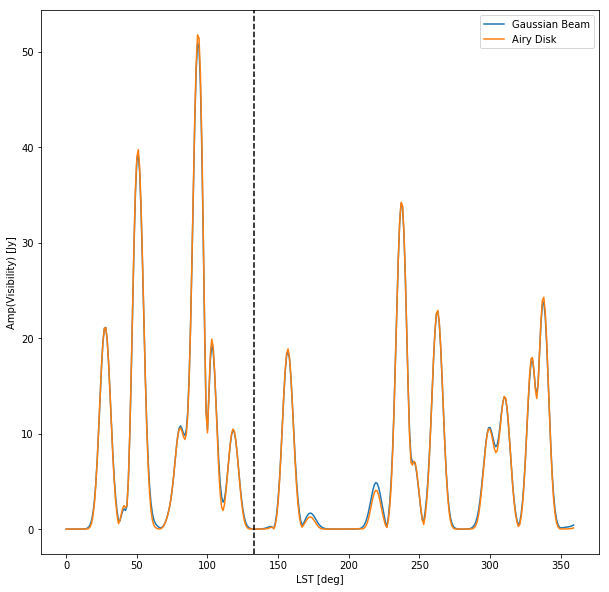

In [26]:

plt.figure(figsize =(10,10))
plt.plot(np.rad2deg(lsts),np.abs(vis_gp[:,1]),label='Gaussian Beam')
plt.plot(np.rad2deg(lsts),np.abs(vis_ad[:,1]),label='Airy Disk')
plt.axvline(np.rad2deg(lsts[133]),ls='dashed',color='black')
plt.xlabel('LST [deg]')
plt.ylabel('Amp(Visibility) [Jy]')
plt.legend(loc='best')

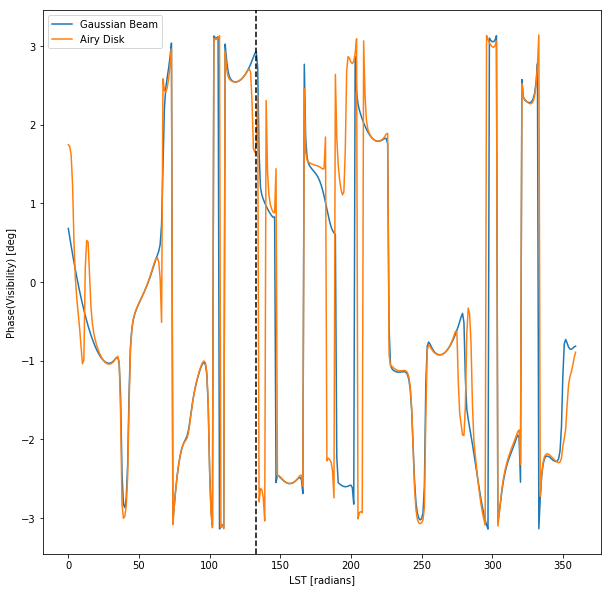

In [27]:
plt.figure(figsize =(10,10))
plt.plot(np.rad2deg(lsts),np.angle(vis_gp[:,1]),label='Gaussian Beam')
plt.plot(np.rad2deg(lsts),np.angle(vis_ad[:,1]),label='Airy Disk')
plt.axvline(np.rad2deg(lsts[133]),ls='dashed',color='black')
plt.xlabel('LST [radians]')
plt.ylabel('Phase(Visibility) [deg]')
plt.legend(loc='best')

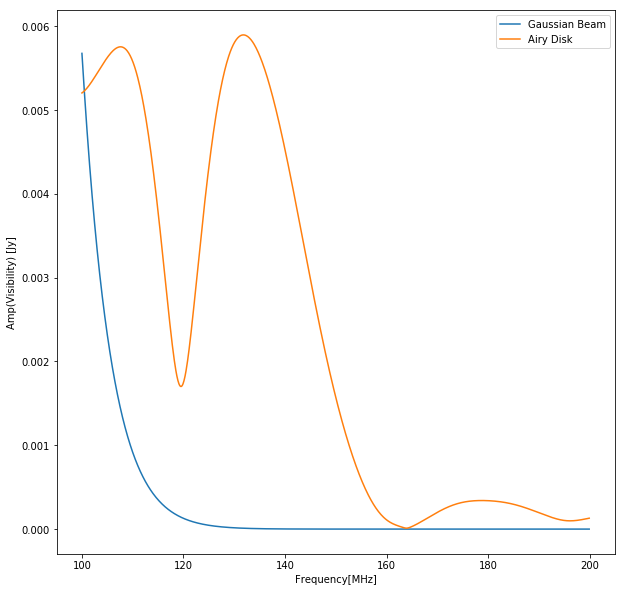

In [28]:
plt.figure(figsize =(10,10))
plt.plot(freqs,np.abs(vis_gp[133]),label='Gaussian Beam')
plt.plot(freqs,np.abs(vis_ad[133]),label='Airy Disk')
plt.xlabel('Frequency[MHz]')
plt.ylabel('Amp(Visibility) [Jy]')
plt.legend(loc='best')


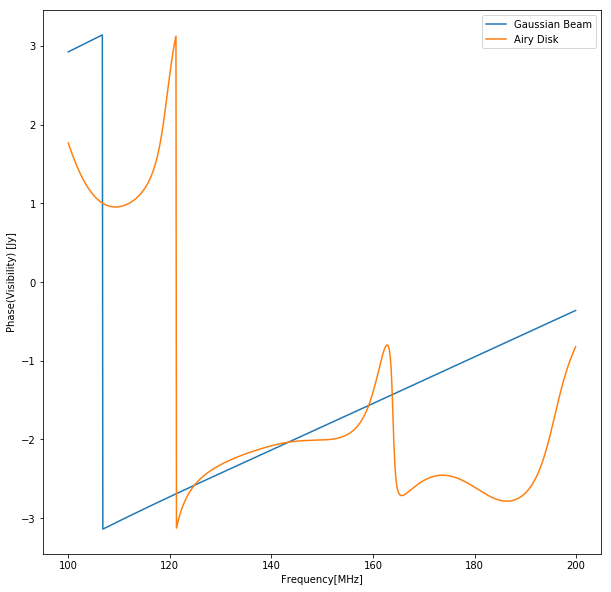

In [29]:

plt.figure(figsize =(10,10))
plt.plot(freqs,np.angle(vis_gp[133]),label='Gaussian Beam')
plt.plot(freqs,np.angle(vis_ad[133]),label='Airy Disk')
plt.xlabel('Frequency[MHz]')
plt.ylabel('Phase(Visibility) [Jy]')
plt.legend(loc='best')

$\textbf{Visibility Waterfall}$

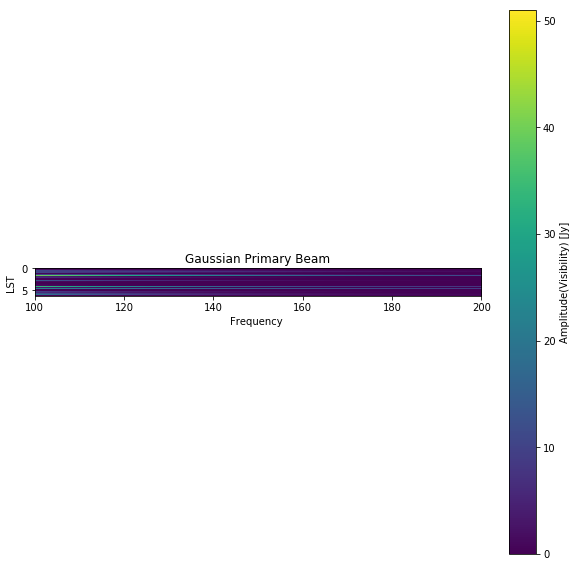

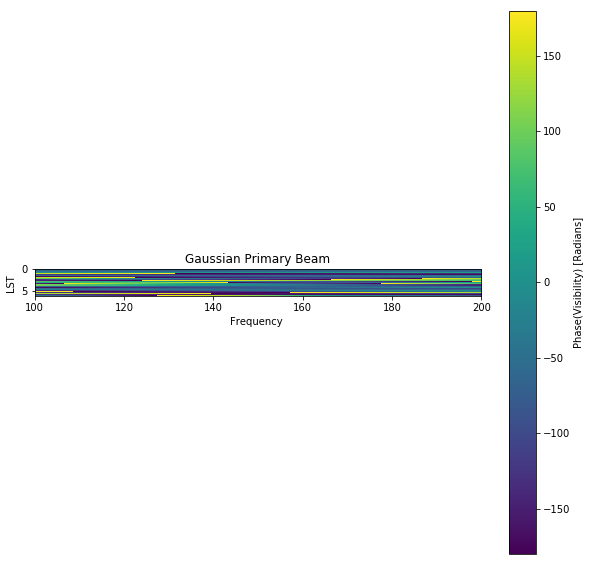

In [30]:
extent =[freqs[0],freqs[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("Gaussian Primary Beam")
plt.imshow(np.abs(vis_gp),extent=extent)
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Gaussian Primary Beam")
plt.imshow(np.angle(vis_gp,deg='deg'),extent=extent)
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

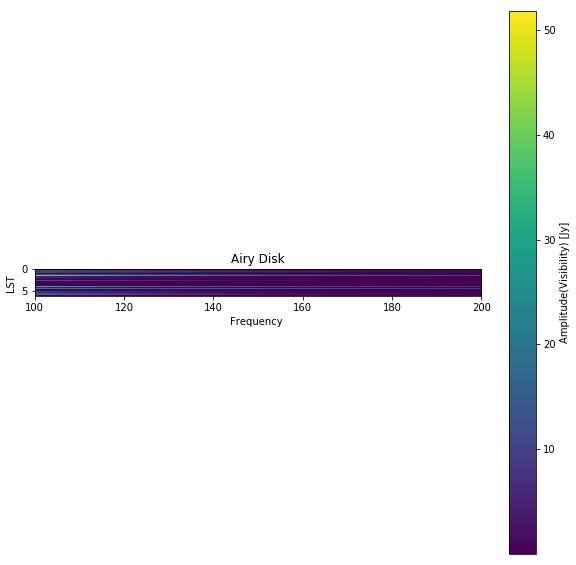

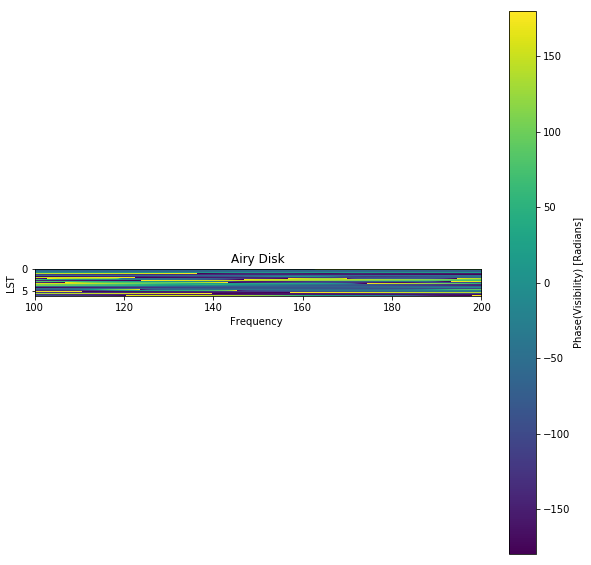

In [38]:
extent =[freqs[0],freqs[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.abs(vis_ad),extent=extent)
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.angle(vis_ad,deg='deg'),extent=extent)
plt.xlabel('Frequency ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

$\textbf{Delay Visibility}$

In [40]:
ddata_gb = np.array([get_delay_vis(vis_gp[lst_i]*jy2mK,window,freqs)[1] for lst_i in range(vis_gp.shape[0])])
ddata_ad = np.array([get_delay_vis(vis_ad[lst_i]*jy2mK,window,freqs)[1] for lst_i in range(vis_ad.shape[0])])

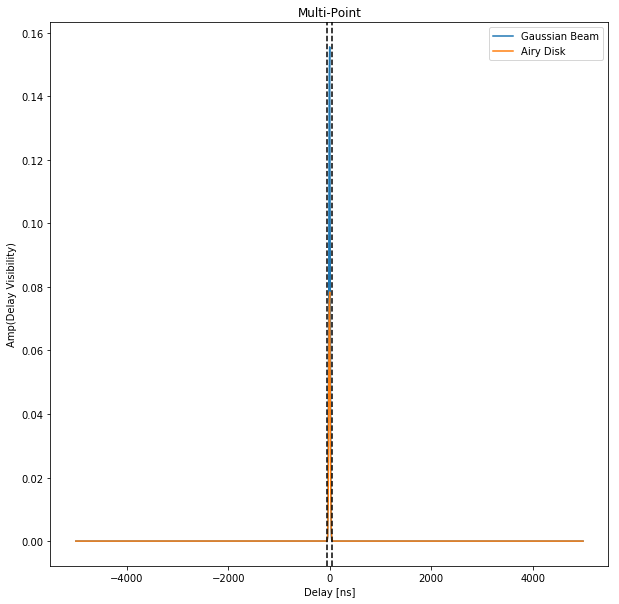

In [56]:
delays = np.fft.fftfreq(freqs.size,freqs[1]*10**6 -freqs[0]*10**6)
delays = np.fft.fftshift(delays)*10**9

plt.figure(figsize=(10,10))
plt.title('Multi-Point')
plt.plot(delays,np.abs(ddata_gb[40]),label='Gaussian Beam')
plt.plot(delays,np.abs(ddata_ad[40]),label='Airy Disk')
plt.axvline(g_dl*10**9,ls='dashed',color='black')
plt.axvline(-g_dl*10**9,ls='dashed',color='black')
plt.xlabel('Delay [ns]')
plt.ylabel('Amp(Delay Visibility)')
plt.legend(loc='best')


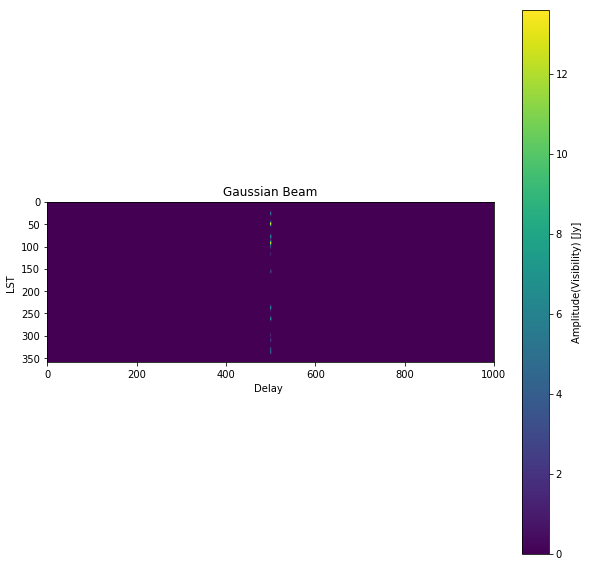

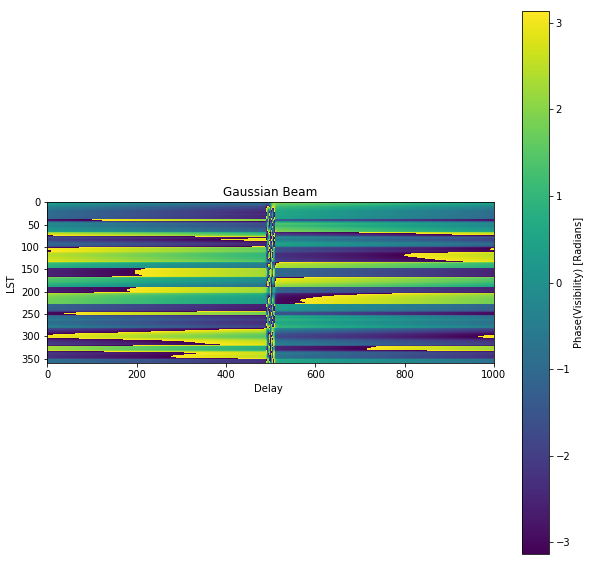

In [57]:
delays = np.fft.fftfreq(freqs.size,freqs[1]*10**6-freqs[0]*10**6)
delays = np.fft.fftshift(delays)
extent =[delays[0],delays[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("Gaussian Beam")
plt.imshow(np.abs(ddata_gb))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay ')
plt.ylabel('LST ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Gaussian Beam")
plt.imshow(np.angle(ddata_gb))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()



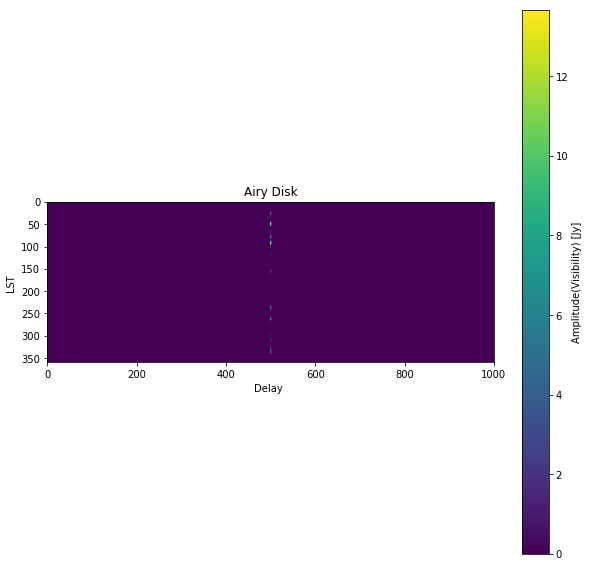

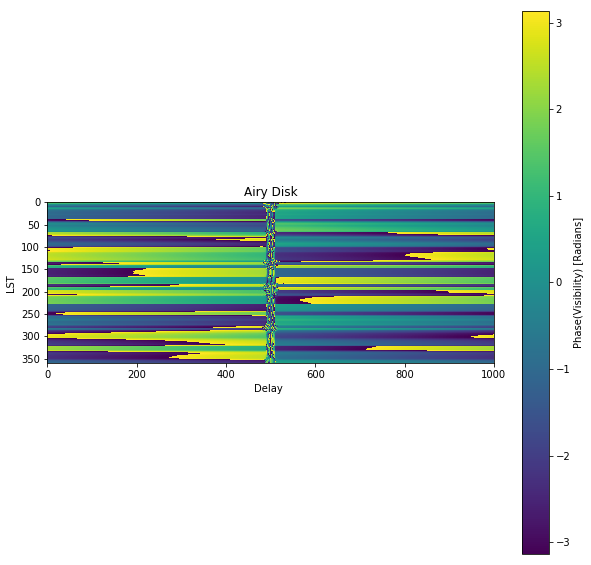

In [58]:
plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.abs(ddata_ad))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay ')
plt.ylabel('LST ')
plt.colorbar(label= r'Amplitude(Visibility) [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("Airy Disk")
plt.imshow(np.angle(ddata_ad))
#plt.axvline(g_dl,ls='dashed',color='white')
#plt.axvline(-g_dl,ls='dashed',color='white')
plt.xlabel('Delay ')
plt.ylabel('LST ')
plt.colorbar(label= r'Phase(Visibility) [Radians]')
plt.show()

$\textbf{Simulating Multi-baseline Visibility}$

In [33]:
RA_0,DEC_0 = 21.41100,-30.72100
lsts = np.array([np.deg2rad(93.0)]) #sources closer to the Zenith
freqs = np.arange(100.0,200.0,0.1)

dish_diam =14.0
d_block = 0.75

vis={}

for ubl_i, redblock in ublDict.iteritems():
    vis_red =np.zeros((len(redblock),freqs.size),dtype='complex')
    for antpair_i in range(len(redblock)):
        ant1_pos, ant2_pos = hera_hex_pos[redblock[antpair_i][0]],  hera_hex_pos[redblock[antpair_i][1]]
        vis_red[antpair_i] = vis_sim_gaussian_beam_bl(ant1_pos,ant2_pos,dish_diam,RA_0,DEC_0,RA,DEC,data_bestfit,freqs,lsts,0.0,0.0,0.0,0.0,0.0,0.0)
    vis[ubl_i] = vis_red
    
    

        

In [124]:
vis.keys()

[(0, 5840, 0),
 (-1617, 2920, 1944),
 (1617, 4380, -1944),
 (809, 2190, -972),
 (2426, 3650, -2916),
 (-809, 5110, 972),
 (3235, 0, -3888),
 (-2426, 2190, 2916),
 (0, 4380, 0),
 (-809, 3650, 972),
 (1617, 2920, -1944),
 (809, 3650, -972),
 (2426, 2190, -2916),
 (-809, 2190, 972),
 (-2426, 3650, 2916),
 (-3235, 1460, 3888),
 (3235, 1460, -3888),
 (-809, 730, 972),
 (-3235, 2920, 3888),
 (3235, 2920, -3888),
 (-2426, 730, 2916),
 (1617, 0, -1944),
 (-1617, 4380, 1944),
 (809, 730, -972),
 (1617, 1460, -1944),
 (809, 5110, -972),
 (2426, 730, -2916),
 (-1617, 1460, 1944),
 (0, 2920, 0),
 (0, 1460, 0)]

In [125]:
visdelay ={}

for ubl_j, vis_i in vis.iteritems():
    vis_redblock=[]
    
    for bl_j in range(len(vis_i)):
        vis_redblock.append(get_delay_vis(vis_i[bl_j]*jy2mK,window,freqs)[1])
        
    visdelay[np.linalg.norm(ubl_j)]=vis_redblock
    
    
    
    


In [126]:

bllenDick =[np.linalg.norm(visdelay.keys()[i]) for i in range(len(visdelay.keys()))] 

bllenvecs_sorted = sorted(bllenDick)

bllenvecs_sorted,len(bllenDick)

([1460.0,
  1460.1934803306033,
  2528.6013920742826,
  2528.9058899057513,
  2919.8330431721606,
  2920.0,
  3862.6707082017747,
  3862.8269440915938,
  3862.870046998734,
  4380.0,
  4380.026483938196,
  5057.491967368806,
  5057.842326526204,
  5264.126898166494,
  5264.158527248206,
  5264.348867618863,
  5840.0,
  5840.219944488393],
 18)

In [132]:
visdelay_std=np.array([visdelay[bllenvecs_sorted[j]][0] for j in range(len(bllenvecs_sorted))]).T
           
     

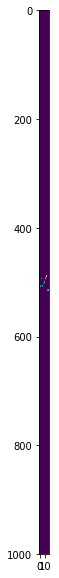

In [135]:
plt.figure(figsize=(10,10))

plt.imshow(np.abs(visdelay_std))


5